# Advanced Machine Learning
## Project 1 - Logistic Regression with Cyclic Coordinate Descent

---

Binda Michal, Kutak Wojciech, Legczylin Michail

In [5]:
import sys
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

sys.path.append("../Task2")
sys.path.append("../Task1")

from implementation.LogRegCCD import LogRegCCD
from implementation.measures import Measure
from synthetic_dataset import generate_synthetic_data

seed = 42
np.random.seed(seed)
random.seed(seed)

DATA_PATH = "../data/"

## Synthetic dataset
---

In [2]:
def compute_roc_and_balanced_acc_score(X, y, model):
    y_proba = cross_val_predict(model, X, y, cv=5, method="predict_proba")
    if len(y_proba.shape) == 2:
        y_proba = y_proba[:, 1]
    y_pred = np.where(y_proba > 0.5, 1.0, 0.0)
    roc_auc = roc_auc_score(y, y_proba)
    balanced_acc = balanced_accuracy_score(y, y_pred)
    return roc_auc, balanced_acc

#### 1. Balanced vs unbalanced datasets

Check how ROC and Balanced accuracy looks like. 

How harder is it to classify class $Y=1$ than $Y=0$ when there is a small number of samples per class?

In [3]:
P = np.linspace(0.1, 0.9, 9)
G = np.array([0.0, 0.5, 0.8, 0.9])
d = 1000
n = 604

shape = (len(P), len(G))
sklearn_scores = {"roc_auc": np.zeros(shape), "balanced_accuracy": np.zeros(shape)}
logregccd_scores = {"roc_auc": np.zeros(shape), "balanced_accuracy": np.zeros(shape)}
for p_idx, p in enumerate(P):
    for g_idx, g in tqdm([*enumerate(G)], f"P:{p}"):
        X, y = generate_synthetic_data(p, n, d, g)
        X, y = X.to_numpy(), y.to_numpy()

        sk_logistic = LogisticRegression(penalty=None)
        sk_roc_auc, sk_bal_acc = compute_roc_and_balanced_acc_score(X, y, sk_logistic)
        sklearn_scores["roc_auc"][p_idx, g_idx] = sk_roc_auc
        sklearn_scores["balanced_accuracy"][p_idx, g_idx] = sk_bal_acc

        ccd_logistic = LogRegCCD()
        ccd_roc_auc, ccd_bal_acc = compute_roc_and_balanced_acc_score(X, y, ccd_logistic)
        logregccd_scores["roc_auc"][p_idx, g_idx] = ccd_roc_auc
        logregccd_scores["balanced_accuracy"][p_idx, g_idx] = ccd_bal_acc

P:0.9: 100%|██████████| 4/4 [00:28<00:00,  7.12s/it]


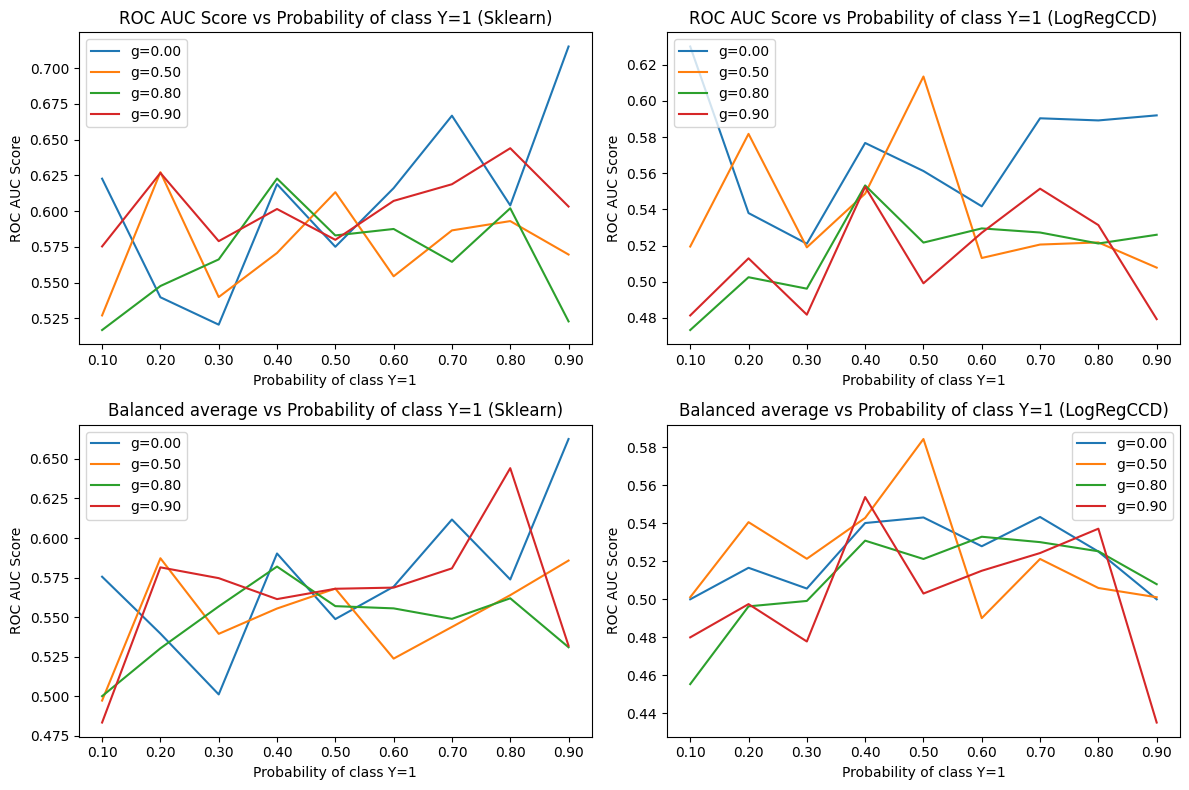

In [48]:
def generate_plots(sklearn_scores, logregccd_scores, labels, titles, xlabels, xticks):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    for i in range(sklearn_scores["roc_auc"].shape[1]):
        axs[0, 0].plot(sklearn_scores["roc_auc"][:, i], label=labels[i])
        axs[0, 1].plot(logregccd_scores["roc_auc"][:, i], label=labels[i])
        axs[1, 0].plot(sklearn_scores["balanced_accuracy"][:, i], label=labels[i])
        axs[1, 1].plot(logregccd_scores["balanced_accuracy"][:, i], label=labels[i])

    for i in range(2):
        for j in range(2):
            axs[i, j].set_title(titles[i][j])
            axs[i, j].set_xticks(xticks[0], xticks[1])
            axs[i, j].set_xlabel(xlabels[i][j])
            axs[i, j].set_ylabel("ROC AUC Score")
            axs[i, j].legend()

    fig.tight_layout()
    plt.show()

generate_plots(sklearn_scores, logregccd_scores, labels=[f"g={g:.2f}" for g in G],
               titles=[
                   ["ROC AUC Score vs Probability of class Y=1 (Sklearn)", "ROC AUC Score vs Probability of class Y=1 (LogRegCCD)"],
                   ["Balanced average vs Probability of class Y=1 (Sklearn)", "Balanced average vs Probability of class Y=1 (LogRegCCD)"]
               ],
               xlabels=[
                   ["Probability of class Y=1", "Probability of class Y=1"],
                   ["Probability of class Y=1", "Probability of class Y=1"]
               ],
               xticks=[range(len(P)), [f"{p:.2f}" for p in P]],
)

#### 2. Overall small cardinality

Given that datasets are balanced, I suspect that the classification results are much worse for 
highly correlated data.

In [38]:
p = 0.5
G = np.array([0.0, 0.5, 0.8, 0.9])
d = 500
N = np.linspace(50, 500, 10, dtype=np.int32)

shape = (len(N), len(G))
sklearn_scores_ng = {"roc_auc": np.zeros(shape), "balanced_accuracy": np.zeros(shape)}
logregccd_scores_ng = {"roc_auc": np.zeros(shape), "balanced_accuracy": np.zeros(shape)}
for n_idx, n in enumerate(N):
    for g_idx, g in tqdm([*enumerate(G)], f"N:{n}"):
        X, y = generate_synthetic_data(p, n, d, g)
        X, y = X.to_numpy(), y.to_numpy()

        sk_logistic = LogisticRegression(penalty=None)
        sk_roc_auc, sk_bal_acc = compute_roc_and_balanced_acc_score(X, y, sk_logistic)
        sklearn_scores_ng["roc_auc"][n_idx, g_idx] = sk_roc_auc
        sklearn_scores_ng["balanced_accuracy"][n_idx, g_idx] = sk_bal_acc

        ccd_logistic = LogRegCCD()
        ccd_roc_auc, ccd_bal_acc = compute_roc_and_balanced_acc_score(X, y, ccd_logistic)
        logregccd_scores_ng["roc_auc"][n_idx, g_idx] = ccd_roc_auc
        logregccd_scores_ng["balanced_accuracy"][n_idx, g_idx] = ccd_bal_acc

N:500: 100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


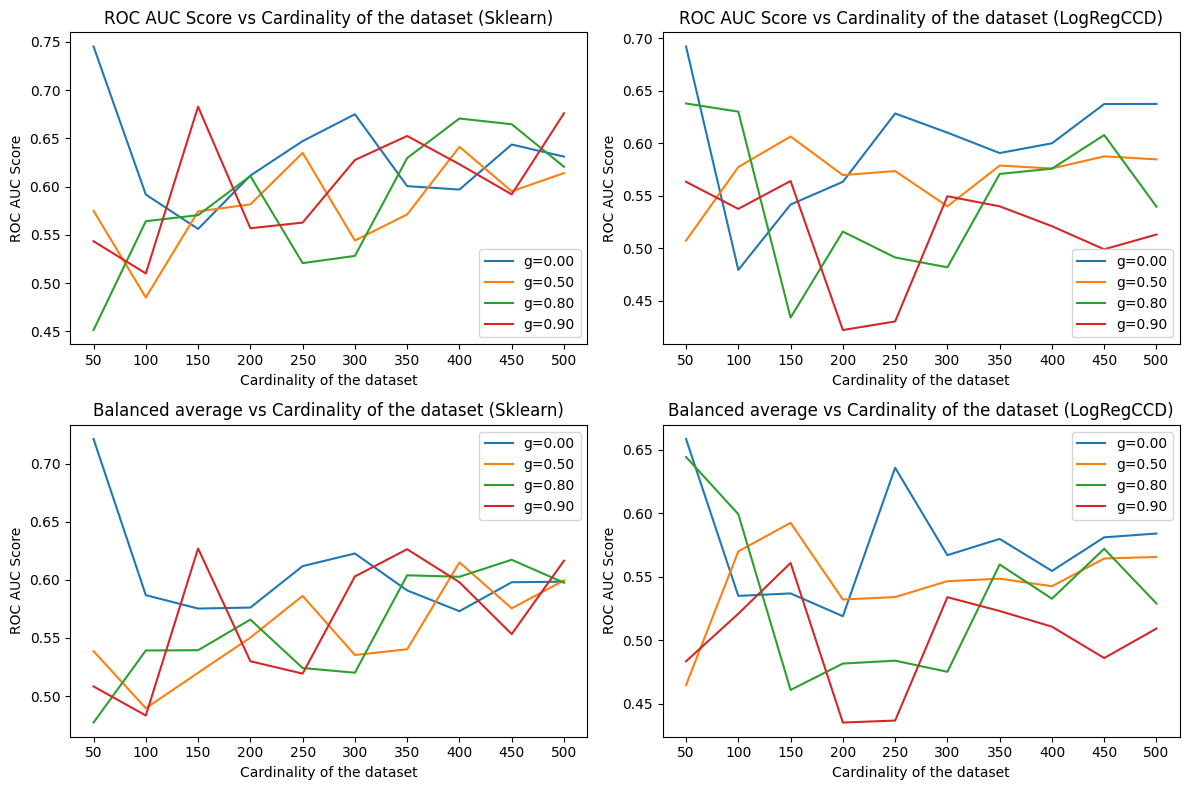

In [49]:
generate_plots(sklearn_scores_ng, logregccd_scores_ng, labels=[f"g={g:.2f}" for g in G],
               titles=[
                   ["ROC AUC Score vs Cardinality of the dataset (Sklearn)", "ROC AUC Score vs Cardinality of the dataset (LogRegCCD)"],
                   ["Balanced average vs Cardinality of the dataset (Sklearn)", "Balanced average vs Cardinality of the dataset (LogRegCCD)"]
               ],
               xlabels=[
                   ["Cardinality of the dataset", "Cardinality of the dataset"],
                   ["Cardinality of the dataset", "Cardinality of the dataset"]
               ],
               xticks=[range(len(N)), [f"{n}" for n in N]],
)

### 3. Dimensionality

In [41]:
p = 0.5
G = np.array([0.0, 0.5, 0.8, 0.9])
D = np.linspace(100, 1000, 10, dtype=np.int32)
n = 500

shape = (len(D), len(G))
sklearn_scores_dg = {"roc_auc": np.zeros(shape), "balanced_accuracy": np.zeros(shape)}
logregccd_scores_dg = {"roc_auc": np.zeros(shape), "balanced_accuracy": np.zeros(shape)}
for d_idx, d in enumerate(D):
    for g_idx, g in tqdm([*enumerate(G)], f"D:{d}"):
        X, y = generate_synthetic_data(p, n, d, g)
        X, y = X.to_numpy(), y.to_numpy()

        sk_logistic = LogisticRegression(penalty=None)
        sk_roc_auc, sk_bal_acc = compute_roc_and_balanced_acc_score(X, y, sk_logistic)
        sklearn_scores_dg["roc_auc"][d_idx, g_idx] = sk_roc_auc
        sklearn_scores_dg["balanced_accuracy"][d_idx, g_idx] = sk_bal_acc

        ccd_logistic = LogRegCCD()
        ccd_roc_auc, ccd_bal_acc = compute_roc_and_balanced_acc_score(X, y, ccd_logistic)
        logregccd_scores_dg["roc_auc"][d_idx, g_idx] = ccd_roc_auc
        logregccd_scores_dg["balanced_accuracy"][d_idx, g_idx] = ccd_bal_acc

D:100:  75%|███████▌  | 3/4 [00:02<00:00,  1.49it/s]d:\Dev\AML\AdvancedMachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:1000: 100%|██████████| 4/4 [00:28<00:00,  7.16s/it]


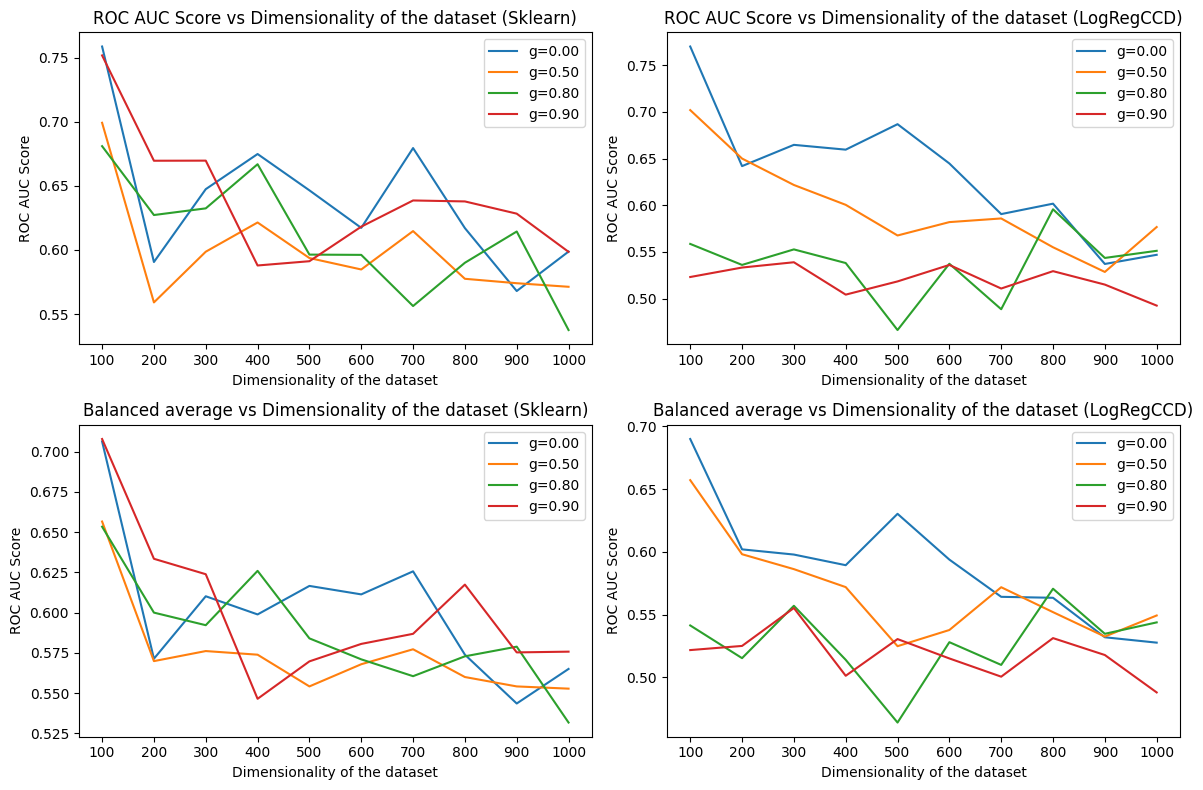

In [50]:
generate_plots(sklearn_scores_dg, logregccd_scores_dg, labels=[f"g={g:.2f}" for g in G],
               titles=[
                   ["ROC AUC Score vs Dimensionality of the dataset (Sklearn)", "ROC AUC Score vs Dimensionality of the dataset (LogRegCCD)"],
                   ["Balanced average vs Dimensionality of the dataset (Sklearn)", "Balanced average vs Dimensionality of the dataset (LogRegCCD)"]
               ],
               xlabels=[
                   ["Dimensionality of the dataset", "Dimensionality of the dataset"],
                   ["Dimensionality of the dataset", "Dimensionality of the dataset"]
               ],
               xticks=[range(len(D)), [f"{d}" for d in D]],
)

## Comparing real-world datasets
---

In [3]:
def compute_metrics(X, y, model):
    y_proba = model.predict_proba(X)

    # Check if y_proba is 2D and take the second column (probability of class 1)
    if len(y_proba.shape) == 2:
        y_proba = y_proba[:, 1]
    y_pred = np.where(y_proba > 0.5, 1.0, 0.0)

    # Compute metrics
    roc_auc = roc_auc_score(y, y_proba)
    balanced_acc = balanced_accuracy_score(y, y_pred)
    avg_precision = average_precision_score(y, y_proba)
    f1 = f1_score(y, y_pred)
    return roc_auc, balanced_acc, avg_precision, f1

In [ ]:
datasets = [("1137.csv", "AP Colon-Kidney"), ("1158.csv", "AP Breast-Kidney"),
            ("45088.csv", "DLBCL"), ("46611.csv", "Toxicity")]
models = {"sklearn": [], "ccd": []}
metrics = {"sklearn": {"roc_auc": [], "balanced_accuracy": [], "f1": [], "avg_precision": []},
           "ccd": {"roc_auc": [], "balanced_accuracy": [], "f1": [], "avg_precision": []}}

scaler = StandardScaler()
for dataset, title in datasets:
    print(f"Processing dataset: {dataset} ({title})")
    df = pd.read_csv(os.path.join(DATA_PATH, dataset))
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()

    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    sk_logistic = LogisticRegression(penalty=None)
    sk_logistic.fit(X_train, y_train)
    sk_roc_auc, sk_bal_acc, sk_avg_precision, sk_f1 = compute_metrics(X_test, y_test, sk_logistic)
    models["sklearn"].append(sk_logistic)
    metrics["sklearn"]["roc_auc"].append(sk_roc_auc)
    metrics["sklearn"]["balanced_accuracy"].append(sk_bal_acc)
    metrics["sklearn"]["avg_precision"].append(sk_avg_precision)
    metrics["sklearn"]["f1"].append(sk_f1)
    print(f"\tSklearn ROC AUC: {sk_roc_auc:.4f}, Balanced Accuracy: {sk_bal_acc:.4f}, "
          f"Avg Precision: {sk_avg_precision:.4f}, F1: {sk_f1:.4f}")

    ccd_logistic = LogRegCCD()
    ccd_logistic.fit(X_train, y_train)
    ccd_roc_auc, ccd_bal_acc, ccd_avg_precision, ccd_f1 = compute_metrics(X_test, y_test, ccd_logistic)
    models["ccd"].append(ccd_logistic)
    metrics["ccd"]["roc_auc"].append(ccd_roc_auc)
    metrics["ccd"]["balanced_accuracy"].append(ccd_bal_acc)
    metrics["ccd"]["avg_precision"].append(ccd_avg_precision)
    metrics["ccd"]["f1"].append(ccd_f1)
    print(f"\tLogRegCCD ROC AUC: {ccd_roc_auc:.4f}, Balanced Accuracy: {ccd_bal_acc:.4f}, "
          f"Avg Precision: {ccd_avg_precision:.4f}, F1: {ccd_f1:.4f}")

    print("-" * 80)

Processing dataset: 1137.csv (AP Colon-Kidney)
	Sklearn ROC AUC: 0.9977, Balanced Accuracy: 0.9816, Avg Precision: 0.9974, F1: 0.9796
	LogRegCCD ROC AUC: 0.5000, Balanced Accuracy: 0.5000, Avg Precision: 0.4455, F1: 0.0000
--------------------------------------------------------------------------------
Processing dataset: 1158.csv (AP Breast-Kidney)
	Sklearn ROC AUC: 1.0000, Balanced Accuracy: 0.9929, Avg Precision: 1.0000, F1: 0.9903
	LogRegCCD ROC AUC: 0.6335, Balanced Accuracy: 0.6225, Avg Precision: 0.5035, F1: 0.6129
--------------------------------------------------------------------------------
Processing dataset: 45088.csv (DLBCL)
	Sklearn ROC AUC: 0.8125, Balanced Accuracy: 0.6667, Avg Precision: 0.6951, F1: 0.5000
	LogRegCCD ROC AUC: 0.3750, Balanced Accuracy: 0.3750, Avg Precision: 0.2232, F1: 0.1818
--------------------------------------------------------------------------------
Processing dataset: 46611.csv (Toxicity)
	Sklearn ROC AUC: 0.6439, Balanced Accuracy: 0.6061, Av

In [4]:
print("Sklearn: Intercept:", models["sklearn"][0].intercept_, "Coeffs:", models["sklearn"][0].coef_, "Max coeff:", np.max(np.abs(models["sklearn"][0].coef_)))
print("LogRegCCD: Intercept:", models["ccd"][0].beta0_, "Coeffs:", models["ccd"][0].beta_, "Max coeff:", np.max(np.abs(models["ccd"][0].beta_)))


Sklearn: Intercept: [-0.00571083] Coeffs: [[-0.00065634 -0.00155229  0.00700691 ... -0.00516228 -0.0016417
  -0.00059265]] Max coeff: 0.04370296109978365
LogRegCCD: Intercept: -0.06424226872835359 Coeffs: [ 0.  0.  0. ... -0. -0. -0.] Max coeff: 0.0
